## Project description

In this project, we utilize a Long Short-Term Memory (LSTM) neural network to predict Bitcoin (BTC) prices against the US Dollar (USDT) using historical price data. The model is trained on data collected from the Binance API, with the goal of making accurate predictions for future price movements. The project demonstrates data preprocessing, feature engineering, model creation, and evaluation.

### Importing Libraries

In [109]:
import requests
import json
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### API Setup
Here we define the endpoint for Binance’s API, which provides historical price data for BTCUSDT at a 2-hour interval, starting from 2018.

In [67]:
# define the API endpoint
endpoint = 'https://api.binance.com/api/v3/klines'

In [81]:
# define the parameters for the API request
symbol = 'BTCUSDT'
interval = '2h'
startTime = '1514764800000'  # 2018-01-01 00:00:00
endTime = str(int(time.time()) * 1000)  # current time in milliseconds

In [82]:
# create an empty DataFrame to store the results
cols = ['timestamp','open', 'high', 'low', 'close', 'volume', 'close_time',
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
        'taker_buy_quote_asset_volume', 'ignore']
df = pd.DataFrame(columns=cols)

### Feature Engineering

We initiate an API loop to gather all available historical data by making multiple requests and appending the results to a pandas DataFrame. This continues until all available data is collected.

In [84]:
# loop through the API to get all available historical data
while True:
    # make the API request
    res = requests.get(endpoint, params={'symbol': symbol, 'interval': interval,
                                          'startTime': startTime, 'endTime': endTime,
                                          'limit': 1000})
    
    # check if the request was successful
    if res.status_code != 200:
        print(f'Request failed with status code {res.status_code}.')
        break
    
    # convert the response to a pandas DataFrame
    res_df = pd.DataFrame(res.json(), columns=cols)
    res_df = res_df.astype(float)
    res_df['timestamp'] = pd.to_datetime(res_df['timestamp'], unit='ms')
    res_df.set_index('timestamp', inplace=True)
    
    # append the results to the main DataFrame
    df = pd.concat([df, res_df])
    
    # check if we have reached the end of the available data
    if len(res_df) < 1000:
        break
    
    # update start time for next request
    startTime = str(int(res_df.index[-1].timestamp() * 1000))
    
    # sleep for 1 second before sending the next request
    time.sleep(1)

In [85]:
df.head(5)

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
2018-01-01 00:00:00,NaN,13715.65,13715.65,13155.38,13203.06,827.053205,1.514772e+12,1.114843e+07,9762.0,409.362324,5.520991e+06,0.0
2018-01-01 02:00:00,NaN,13203.00,13611.27,13200.00,13410.03,849.151602,1.514779e+12,1.136764e+07,9676.0,330.156342,4.416546e+06,0.0
2018-01-01 04:00:00,NaN,13434.98,13699.00,13322.15,13558.99,745.036375,1.514786e+12,1.008710e+07,9649.0,315.288693,4.263768e+06,0.0
2018-01-01 06:00:00,NaN,13539.00,13818.55,13510.00,13570.35,557.178461,1.514794e+12,7.615434e+06,8412.0,273.227529,3.735027e+06,0.0
2018-01-01 08:00:00,NaN,13569.98,13735.24,13400.00,13616.99,484.909382,1.514801e+12,6.575049e+06,6861.0,219.279895,2.974658e+06,0.0


In [72]:
# save data to CSV file
df.to_csv('btcusdt_quotes_2h.csv')

In [87]:
df.index = pd.to_datetime(df.index)

In [89]:
# select relevant features
close = df[['close']]
close.head(5)

,close
2018-01-01 00:00:00,13203.06
2018-01-01 02:00:00,13410.03
2018-01-01 04:00:00,13558.99
2018-01-01 06:00:00,13570.35
2018-01-01 08:00:00,13616.99


In [90]:
# rename index
close.index.rename('date_time', inplace=True)

<Axes: xlabel='date_time'>

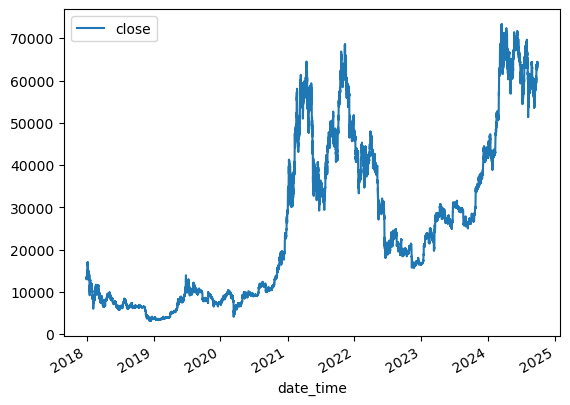

In [91]:
# plot the data
close.plot()

This graph highlights Bitcoin's cyclical nature, characterized by boom and bust cycles. The sharp increases in price (bull markets) are often followed by significant corrections.

### Normalization

We use MinMaxScaler that transforms the data to a specified range, which by default is between 0 and 1. It scales each feature by subtracting the minimum value of the feature and dividing by the range (max - min)

In [92]:
# scale the data
scaler = MinMaxScaler()
close['price_normalized'] = scaler.fit_transform(close[['close']])

/var/folders/6w/ff3qhvbn3gj1tnlvhkrdb_j40000gn/T/ipykernel_21305/3384962261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close['price_normalized'] = scaler.fit_transform(close[['close']])


In [93]:
close = close[['price_normalized']]
close.head(5)

,price_normalized
date_time,
2018-01-01 00:00:00,0.142938
2018-01-01 02:00:00,0.145888
2018-01-01 04:00:00,0.148010
2018-01-01 06:00:00,0.148172
2018-01-01 08:00:00,0.148837


### Train-Test Split and Data Reshaping

The dataset is split into training and testing sets. The training set will be used to fit the model, while the test set will evaluate its performance. Data reshaping is performed to match the LSTM's input requirements (3D tensor format).

In [94]:
# create a function to reshape data 
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [ a for a in df_as_np[i:i+window_size] ]
        X.append(row)
        label = df_as_np[i+window_size][-1]  # get the last value in the window
        y.append(label)
    return np.array(X), np.array(y)[:, np.newaxis]

In [95]:
# set window size and apply our function
WINDOW_SIZE = 96 
X, y = df_to_X_y(close, WINDOW_SIZE)
X.shape, y.shape

((29398, 96, 1), (29398, 1))

In [96]:
# set aside 25% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.25, shuffle = False)

# use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, shuffle=False) 

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((16536, 96, 1),
 (16536, 1),
 (5512, 96, 1),
 (5512, 1),
 (7350, 96, 1),
 (7350, 1))

### Model Building

- LSTM Layers:
The first LSTM layer has 64 units with tanh activation and return_sequences=True. The tanh activation function is commonly used in LSTMs to manage gradient flow effectively, especially when dealing with time-series data. The 64 units strike a balance between model complexity and training speed. return_sequences=True ensures that the LSTM passes the sequence of outputs to the next LSTM layer, which is important for learning long-term dependencies in the data.

- Dropout Layers:
After each LSTM layer, a Dropout of 0.3 is applied to reduce overfitting. Dropout helps by randomly dropping 30% of the units during training, preventing the model from becoming too reliant on specific neurons. This encourages the model to generalize better when predicting on unseen data.

- Dense Layers:
The Dense layer with 32 units and relu activation is added to perform further transformations on the learned features from the LSTM layers. This fully connected layer allows the network to capture more complex patterns. The l2 regularization with a factor of 0.01 penalizes large weights and encourages the network to stay simpler, which also helps prevent overfitting.

- Output layer:
This layer with 1 unit and linear activation is used for the prediction of the next price in the sequence. Since we are predicting a continuous value, a linear activation function is most appropriate.
Optimizer and Loss Function:

The Adam optimizer with a learning rate of 0.001 is chosen due to its ability to adapt the learning rate during training, which helps converge faster and avoids getting stuck in local minima. The Mean Squared Error (MSE) loss function is used because this is a regression problem, and MSE is the most common loss function for such tasks.

In [97]:
# define a sequential model
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model2.add(Dropout(0.3))
model2.add(LSTM(64, activation='tanh', return_sequences=False))
model2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='mse')

model2.summary()

/Users/dashuryadova/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 96, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# fit the model
hystory = model2.fit(X_train, y_train, validation_data=(X_val, y_val), 
           epochs=30, batch_size=64)

Epoch 1/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.2446 - val_loss: 0.0131
Epoch 2/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0092 - val_loss: 0.0010
Epoch 3/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0036 - val_loss: 8.1997e-04
Epoch 4/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 6/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 7/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0030 - val_loss: 6.7963e-04
Epoch 9/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0028 - val_loss: 4.2530e-04
Epoch 11/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0029 - val_loss: 5.7294e-04
Epoch 12/30
25

In [100]:
#make a prediction
test_prediction = model2.predict(X_test)

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [101]:
# evaluate the model
test_loss = model2.evaluate(X_test, y_test)

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3050e-04


### Visualization of the results

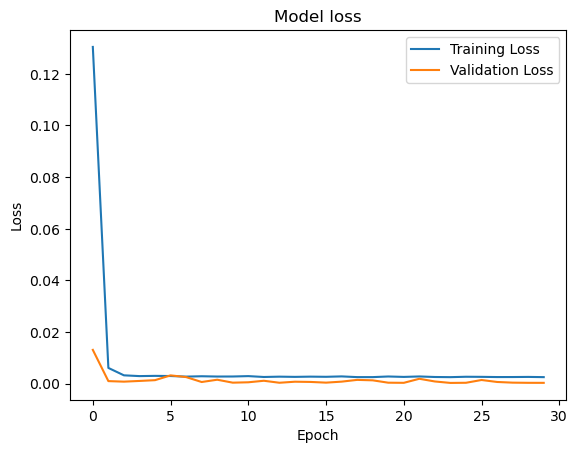

In [102]:
# get the training and validation loss
train_loss = hystory.history['loss']
val_loss = hystory.history['val_loss']

# plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Both training and validation loss drop steeply during the first few epochs, which means that the model quickly learns basic patterns in the data. After that, both losses stabilize and remain low, with little to no divergence between them, which is a good sign. The nearly perfect fit (loss close to 0) may suggest that the model fits the data very well, but it could also indicate potential overfitting if the dataset is too small or too simple.

In [110]:
# calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, test_prediction)

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 0.000705258510489865
Root Mean Squared Error (RMSE): 0.02655670368268368


The results indicate the following:

- Mean Squared Error (MSE): 0.000705
This is the average of the squared differences between the predicted and actual prices. MSE is quite low, which is a good sign, indicating that our model is performing well in predicting the BTC/USDT prices.

- Root Mean Squared Error (RMSE): 0.0266
The RMSE is the square root of the MSE and represents the standard deviation of the prediction errors. RMSE value of 0.0266 means that, on average, our model's predictions are off by around 2.66% (assuming the normalized prices are between 0 and 1). This is also a good result, as it shows that the predictions are fairly accurate.

In [111]:
# convert the normalized predicted and actual test data back to their original scale
y_test_inverse = scaler.inverse_transform(y_test)
test_prediction_inverse = scaler.inverse_transform(test_prediction)

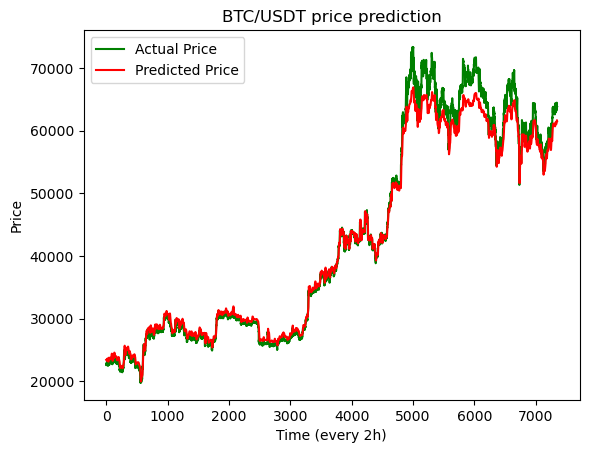

In [112]:
# visualize the model's performance by comparing the actual and predicted test prices on a line plot
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(test_prediction_inverse, label="Predicted Price", color='red')

plt.title('BTC/USDT price prediction')
plt.xlabel('Time (every 2h)')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

- Good performance: LSTM model is able to predict the BTC/USDT price movements quite accurately, suggesting that the model has successfully learned the time-dependent relationships in the dataset.

- Minor deviations: There are some points where the model doesn't perfectly follow the actual price, which could be due to the inherent volatility of BTC prices or the model's limitations in handling extreme price fluctuations.

- Further evaluation: It would be useful to evaluate the model's performance using metrics like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) to quantify the accuracy of the predictions.

## Conclusion:

The LSTM model for predicting USDT price movements performed successfully. After data preprocessing and training, the model showed a good fit, with low and stable training and validation losses. The calculated metrics, MSE = 0.0007 and RMSE = 0.0266, indicate a high level of accuracy, with average prediction errors of only about 2.66%. The model effectively captures the overall trends in BTC/USDT prices, despite minor deviations during sharp price fluctuations.